In [23]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import autograd.numpy as np

import matplotlib.pyplot as plt
from ipywidgets import *

from metric_spaces import MetricData
from metric_spaces.sphere import Sphere, r2_to_angle
from regression.forests import MetricRandomForest 
from regression.trees import MedoidTree

%matplotlib inline
%load_ext autoreload
%autoreload 2

def counted(f):
    def wrapped(*args, **kwargs):
        wrapped.calls += 1
        return f(*args, **kwargs)
    wrapped.calls = 0
    return wrapped

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def gen_data(N, eps=0.1, d=3):
    assert d >= 3
    x = np.random.rand(N*d).reshape((N,d))
    m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,1]) - 10*x[:,2]**3 

    theta = m(x) + eps*np.random.randn(N)
    y = np.c_[np.cos(theta), np.sin(theta)]
    return x, MetricData(Sphere(1), y)


N = 100; eps = 0.5; d=3
x_train, y_train = gen_data(N, eps, d)
x_test, y_test = gen_data(100, eps, d)

y_train.compute_distances()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:


tree = MedoidTree().fit(x_train, y_train)


In [31]:

tree.predict(x_test[0,:])


array([ 0.17743276, -0.98413293])

In [3]:
preds = np.zeros((2, x_test.shape[0], 2))

In [82]:


D = D_mat(M, y_train)
forest_mrf = rf(500, x_train, D, 40)

# N=200, s=150
# CPU times: user 22.4 s, sys: 162 ms, total: 22.6 s
# Wall time: 22.6 s

# N=100,s=75
# CPU times: user 4.3 s, sys: 486 ms, total: 4.78 s
# Wall time: 3.89 s

# N=50,s=40
# CPU times: user 2.02 s, sys: 12.4 ms, total: 2.04 s
# Wall time: 2.04 s

KeyboardInterrupt: 

In [83]:
def depth(node):
    if not node.split:
        return 1
    else:
        return 1 + max(depth(node.left), depth(node.right))
    

In [84]:
ss = np.array([10, 20, 40, 80, 160, 320, 640, 1240, 2500, 4000])
# cs_std = np.zeros_like(ss)
cs_kmeans = np.zeros_like(ss)
ds_kmeans = np.zeros_like(ss)

for i in range(ss.shape[0]):
    counter_fv = counted(M.frechet_var)
    f = rf_kmeans(1, x_train, y_train, counter_fv, ss[i])
    ds_kmeans[i] = depth(f[0])
    cs_kmeans[i] = counter_fv.calls
    
#     counter_fv = counted(circle.frechet_var)
#     forest_std = rf_std(1, x_train, y_train, counter_fv, ss[i])
#     cs_std[i] = counter_fv.calls

10 1
20 3
40 7
80 15
160 35
320 81
640 157
1240 299
2500 591
4000 963


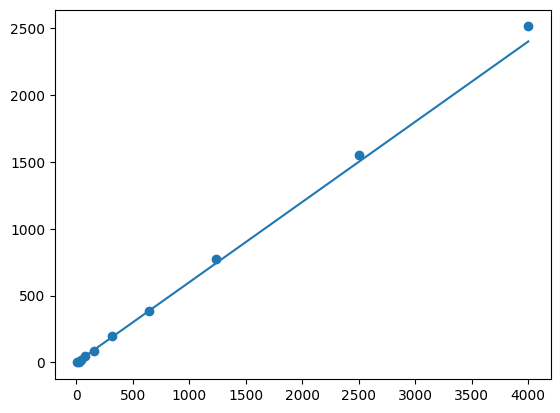

In [65]:
# plt.plot(ss, [1, 3, 9, 23, 35, 73,155, 289, 605, 973])
# plt.subplot(1,2,1)
plt.scatter(ss, cs_kmeans, label='kmeans')
plt.plot(ss, ss*d/5)
# plt.subplot(1,2,2)
# plt.scatter(ss, ds_kmeans, label='kmeans')
# plt.plot(ss, np.log(ss))
# plt.plot(ss,cs_std, label='std')

In [9]:
for i in range(x_test.shape[0]):
    preds[0,i,:] = circle.fm(y_train, rf_weights(forest_mrf, x_test[i,:]))
    preds[1,i,:] = circle.fm(y_train, rf_weights(forest_kmeans, x_test[i,:]))

array([2.03871592, 2.04108491])

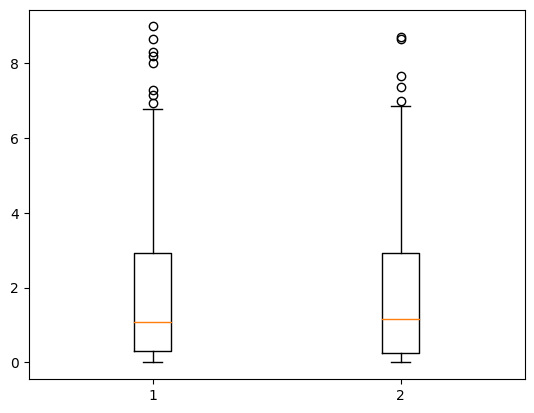

In [10]:
%matplotlib inline
errs = np.zeros((2, x_test.shape[0]))
for i in range(x_test.shape[0]):
    errs[0,i] = circle.d(y_test[i], preds[0,i,:])
    errs[1,i] = circle.d(y_test[i], preds[1,i,:])

plt.boxplot(errs[:,~np.isnan(errs[1,:])].T)

errs[:,~np.isnan(errs[1,:])].mean(axis=1)